In [1]:
from sklearn.datasets import make_circles, make_spd_matrix, make_swiss_roll
import numpy as np

n = 50
d = 2

noisy_circles, y = make_circles(n_samples=n*2, factor=.5, noise=0.075, random_state=0)
mu0 = noisy_circles[y == 0]
mu0 = (mu0 - mu0.mean(axis=0, keepdims=True)) / mu0.std(axis=0, keepdims=True)
mu1 = 2.5 * (np.random.rand(n, d) - .5)

# d = 2
# mu0 = make_swiss_roll(n_samples=n)[0][:, (0, 2)]
# mu0 = (mu0 - mu0.mean(axis=0, keepdims=True)) / mu0.std(axis=0, keepdims=True)
# mu1 = 2.5 * (np.random.rand(n, d) - .5)


#d = 500
#mu_s = np.ones(d)
#mu_s = np.array([i*float(np.random.rand(1,1)) for i in mu_s])
#cov_s = make_spd_matrix(d, random_state=0)
#mu0 = np.random.multivariate_normal(mu_s, cov_s, n)
#mu1 = 2.5 * (np.random.rand(n, d) - .5)

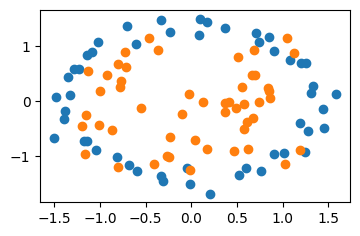

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [4, 2.5]

if d == 2:
    plt.scatter(mu0[:, 0], mu0[:, 1])
    plt.scatter(mu1[:, 0], mu1[:, 1])


In [3]:
import torch

mu1_th = torch.tensor(mu1, dtype=torch.float32)

source = torch.clone(mu1_th) + 1.
source.requires_grad_()
target = torch.tensor(mu0, dtype=torch.float32, requires_grad=False)

source0 = torch.clone(source)

In [4]:
import ot

def wass(x, y):
    dists = ot.utils.dist(x, y)
    a = torch.ones(x.shape[0])/x.shape[0]
    b = torch.ones(y.shape[0])/y.shape[0]
    
    return ot.emd2(a, b, dists)

In [5]:
source.requires_grad

True

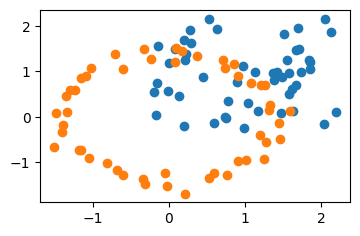

In [6]:
if d == 2:
    plt.scatter(source[:, 0].detach().numpy(), source[:, 1].detach().numpy())
    plt.scatter(target[:, 0].detach().numpy(), target[:, 1].detach().numpy())

In [ ]:
from torch.optim import SGD, Adam
from torch import nn

from losses import F_eps

torch.manual_seed(0)

epsilon = 5e-2
n_samples = 10
n_iter_inner = 20
n_iter_outer = 1000
learning_rate_inner = .01
learning_rate_outer = .005

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

        # Initialisation He pour les poids
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def F_nn(x, y, model, p):
    pos_x_1d = torch.argsort(model(x).flatten())
    pos_y_1d = torch.argsort(model(y).flatten())
    return torch.mean(torch.sum(torch.abs(x[pos_x_1d] - y[pos_y_1d]) ** p, dim=-1), dim=0)

custom_F = lambda x, y, model: F_nn(x, y, model, p=2)

losses = []
losses_wass = []
sources = [source.clone().detach().numpy()]
model = SimpleNN(input_size=d, hidden_size=256, output_size=1)
opt_model = Adam(model.parameters(), lr=learning_rate_inner)
opt_source = Adam([source], lr=learning_rate_outer)
for _ in range(n_iter_outer):
    mem_params = []
    mem_loss_inner = []
    for _ in range(n_iter_inner):
        loss = F_eps(model, source, target, fun=custom_F, n_samples=n_samples, epsilon=epsilon)
        mem_loss_inner.append(loss.item())
        mem_params.append(model.state_dict())
        loss.backward()
        opt_model.step()
        opt_model.zero_grad()
    model.load_state_dict(mem_params[np.argmin(mem_loss_inner)])
    
    loss = custom_F(source, target, model)
    loss.backward()
    losses.append(loss.item())
    opt_source.step()
    opt_source.zero_grad()
    sources.append(source.clone().detach().numpy())
    losses_wass.append(wass(source, target).detach().numpy())

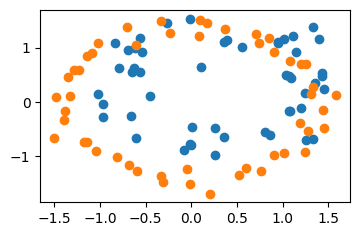

In [8]:
if d == 2:
    plt.scatter(source[:, 0].detach().numpy(), source[:, 1].detach().numpy())
    plt.scatter(target[:, 0].detach().numpy(), target[:, 1].detach().numpy())

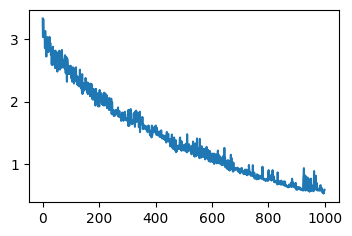

In [9]:
plt.plot(losses)

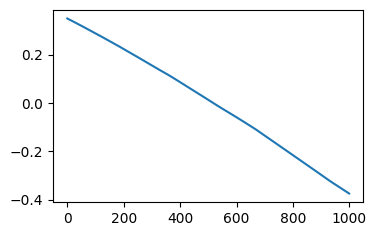

In [10]:
plt.plot(np.log10(losses_wass))

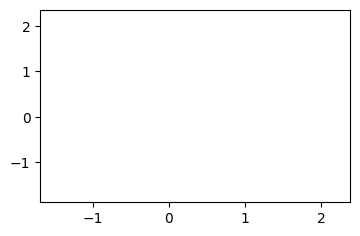

In [11]:
import matplotlib.pyplot as plt
from celluloid import Camera

fig = plt.figure()
camera = Camera(fig)

for s in sources[::10]:
    plt.scatter(s[:, 0], s[:, 1], color="blue")
    plt.scatter(target[:, 0].detach().numpy(), target[:, 1].detach().numpy(), color="orange")
    
    camera.snap()

animation = camera.animate()
# animation.save('animation.gif', writer = 'pillow')

In [12]:
from IPython.display import HTML
animation = camera.animate()
HTML(animation.to_html5_video())